In [1]:
from zlib import crc32

theory = crc32('Сайранов'.lower().encode('utf-8'))%3+1
practice = crc32('Sayranov'.lower().encode('utf-8'))%3+1
theory, practice

(1, 2)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from tqdm import tqdm
from collections import namedtuple, OrderedDict

# Данные
В качестве данных возьмем датасет Two Moons

In [13]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

moons = datasets.make_moons(n_samples=1000, noise=0.3, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(moons[0], moons[1])

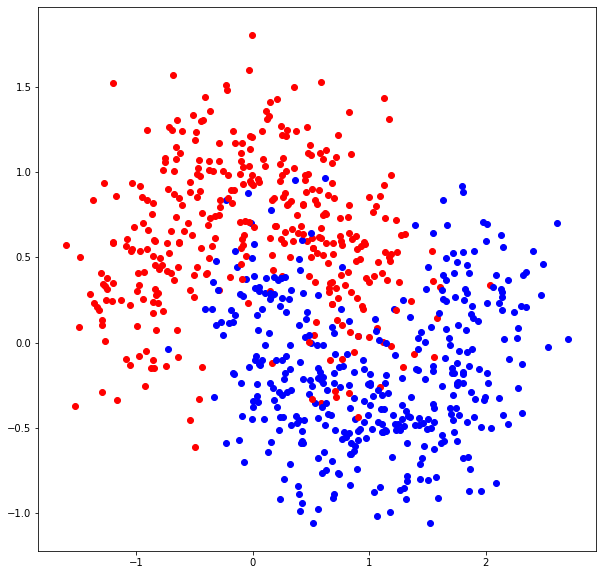

In [14]:
colors = ['r', 'b']

plt.figure(figsize=(10, 10))
for i in range(x_train.shape[0]):
    plt.scatter(x_train[i, 0], x_train[i, 1], color=colors[y_train[i]])

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# Построим простую модель 

In [16]:
class SimpleNetwork(nn.Module):
        
    def __init__(self, in_feat=2):
        super(SimpleNetwork, self).__init__()
        
        layers = []
        layers.append(nn.Linear(in_feat, 20))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(20, 10))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(10, 1))
        layers.append(nn.LogSigmoid())
        
        self.model  = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [17]:
def get_acc(test_loader, model):
    correct = 0
    total = 0
    
    for batch, (x, y) in enumerate(test_loader):
        y = y.float()
        preds = (torch.exp(model(x))[:, 0] > .5).float()
        optimizer.zero_grad()

        correct += (preds == y).float().sum()
        total += len(preds)

    return correct/total

def train(model, train_loader, optimizer, variational=False):
    losses = []
    accs = []

    model.train()

    for batch, (x, y) in tqdm(enumerate(train_loader)):
        if variational:
            x, y = Variable(x), Variable(y)
            
        y = y.float()
        preds = model(x)
        optimizer.zero_grad()
         
        if variational:
            loss = F.binary_cross_entropy_with_logits(preds[:, 0], y) + model.prior_loss()
        else:
            loss = F.binary_cross_entropy_with_logits(preds[:, 0], y)
        loss.backward()
    
        optimizer.step()
        losses.append(float(loss))
    
        with torch.no_grad():
            accs.append(get_acc(test_loader, model))
            
    return losses, accs

In [18]:
model = SimpleNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
non_var_losses, non_var_accs = train(model, train_loader, optimizer)

75it [00:00, 110.29it/s]


# Модель с вариационным нормальным распределением

In [19]:
VariationalParameter = namedtuple('VariationalParameter', ['mean', 'rho', 'eps'])

def prior_std(p):
    stdv = 1
    p_dim = p.dim()
    if p_dim > 1:
        for i in range(p_dim - 1):
            stdv *= p.size()[i + 1]
        stdv = 1 / np.sqrt(stdv)
    else:
        stdv = 1e-2
    return stdv
    
def DKL(parametrs_dict):
    loss = 0
    for p in parametrs_dict.values():
        if isinstance(p, VariationalParameter):
            mean = p.mean
            std = (1 + p.rho.exp()).log()
            std_prior = prior_std(mean)
            loss += ((std.pow(2) + mean.pow(2)) / (2 * std_prior ** 2) - (std / std_prior).log() - 1 / 2).sum()
        else:
            loss += DKL(p)
    return loss

def build_params(parameters_dict, module, epsilon_setting):
    for name, p in parameters_dict.items():
        if isinstance(p, VariationalParameter):
            if p.eps is None:
                parameters_dict[name] = p._replace(eps=Variable(p.mean.data.clone()))
            epsilon_setting(name, parameters_dict[name])
            setattr(module, name, evaluate_prior_params(parameters_dict[name]))
        elif p is None:
            setattr(module, name, None)
        else:
            build_params(p, getattr(module, name), epsilon_setting)

def evaluate_prior_params(variational_parameter):
    return variational_parameter.mean + (1 + variational_parameter.rho.exp()).log() * variational_parameter.eps

class BayesianNeuralNet(nn.Module):
    def __init__(self, model, zero_mean=True, learn_mean=True, learn_rho=True):
        super(BayesianNeuralNet, self).__init__()

        self.model = model
        self.diction = OrderedDict()
        self.variationalize(self.diction, self.model, '', zero_mean,
                            learn_mean, learn_rho)
        self.prior_loss = lambda: DKL(self.diction)

    def variationalize(self, diction, module, prefix, zero_mean,
                       learn_mean, learn_rho):
        to_erase = []
        paras = module._parameters.items()
        for name, p in paras:

            if p is None:
                diction[name] = None
            else:
                stdv = prior_std(p)
                init_rho = np.log(np.exp(stdv) - 1)

                init_mean = p.data.clone()
                if zero_mean:
                    init_mean.fill_(0)

                diction[name] = VariationalParameter(
                    Parameter(init_mean),
                    Parameter(p.data.clone().fill_(init_rho)),
                    None)
                if learn_mean:
                    self.register_parameter(prefix + '_' + name + '_mean', diction[name].mean)
                if learn_rho:
                    self.register_parameter(prefix + '_' + name + '_rho', diction[name].rho)
            to_erase.append(name)

        for name in to_erase:
            delattr(module, name)

        for mname, sub_module in module.named_children():
            sub_diction = OrderedDict()
            self.variationalize(sub_diction, sub_module,
                                prefix + ('_' if prefix else '') +
                                mname, zero_mean,
                                learn_mean, learn_rho)
            diction[mname] = sub_diction

    def forward(self, inputs):
        def get_epsilon_setting(name, p):
            if self.training:
                return p.eps.data.normal_()
            return p.eps.data.zero_()

        build_params(self.diction, self.model, get_epsilon_setting)
        return self.model(inputs)

In [20]:
model = BayesianNeuralNet(SimpleNetwork())
optimizer = optim.Adam(model.parameters(), lr=0.01)
var_losses, var_accs = train(model, train_loader, optimizer, variational=True)

75it [00:01, 53.26it/s]


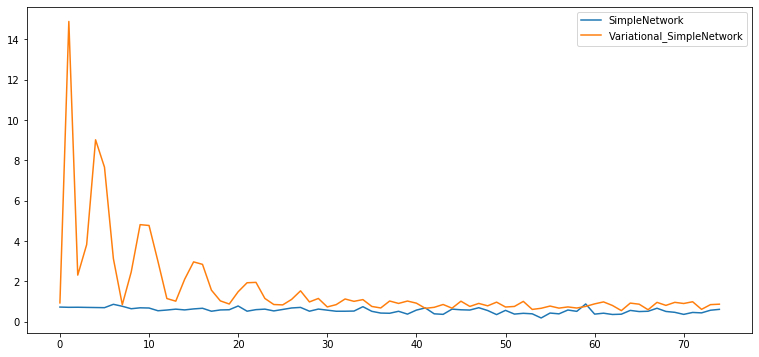

In [25]:
plt.figure(figsize=(13, 6))
plt.plot(non_var_losses, label='SimpleNetwork')
plt.plot(var_losses, label='Variational_SimpleNetwork')
plt.legend()
plt.show()